# Symmetrization of Wannier Hamiltonian and matrices 

By Xiaoxiong Liu : xxliu@physik.uzh.ch

The real-space Wannier Hamiltonian obtained by Wannier90 code generally does not strictly preserve the corresponding symmetry. The slight loss of symmetry will gap the expected band intersections. Berry curvature and orbital magnetic moment are more sensitive to symmetry than energy eigenvalues. In the following, I give details about the symmetrization of Wannier Hamiltonian and matrices.

In WannierBerri, our built-in symmetrization method can enforce symmetrizing Wannier Hamiltonian (Ham_R) and matrices (AA_R, BB_R, CC_R, SS_R) after reading them.

$Ham\_R = <n0|\hat{H}|mR>$

$AA\_R = <n0|\hat{r}|mR>$

$BB\_R = <n0|\hat{H}\cdot(\hat{r}-\hat{R})|mR>$

$CC\_R_c = i \epsilon_{abc} <n0|\hat{r}_a\cdot\hat{H}\cdot(\hat{r}_b-\hat{R}_b)|mR>$

$SS\_R = <n0|\hat{\sigma}|mR>$

They are needed when calculating different quantities:
1. Energy eigenvalue  <-- Ham_R
2. Berry Curvature  <-- Ham_R, AA_R
3. Orbital magnetic moment  <-- Ham_R, AA_R, BB_R, CC_R
4. Spin magnetic moment  <-- SS_R

NOTE: This method only works with Wannier Hamiltonian without maximal localized. 

We will show you two examples:
1. Symmetrize nonmagnetic system with SOC (trigonal Te)
2. Symmetrize magnetic system with SOC (bcc Fe)

In [1]:
#import necessary packages
import wannierberri as wberri
import numpy as np
import matplotlib.pyplot as plt #for plotting figures

## Nonmagnetic system (trigonal Te)

In [2]:
#Reading Wannier Hamiltonian and position element matrix from Te_tb.dat file.
#We bulit to system, `system_Te` without symmetrization and `system_Te_sym` with symmetrization

system_Te=wberri.System_tb(tb_file='./Te_data/Te_tb.dat',berry=True,use_ws=False)
system_Te_sym=wberri.System_tb(tb_file='./Te_data/Te_tb.dat',berry=True,use_ws=False)

#Symmetrization step.
system_Te_sym.symmetrize(
    # positions: positions of each atoms in a unitcell (direct coordinate system)
    positions = np.array([[0.274, 0.274, 0.0],   
                    [0.726, 0.0, 0.33333333],
                   [0.0, 0.726, 0.66666667]]),
    # atom_name: name of each atoms, need to correspond to position order.
    atom_name = ['Te','Te','Te'],
    # projections: should be the same with projection card in wannier90.win
    proj = ['Te:s','Te:p'],
    # soc: with soc or spinless
    soc=True,
    # DFT_code: What code was used to complet the DFT calculation. only support VASP and QE now.
    DFT_code='vasp',
    )

reading TB file ./Te_data/Te_tb.dat ( written on  9May2022 at 22:54:49 )
NOT using ws_dist
Number of wannier functions: 24
Number of R points: 195
Recommended size of FFT grid [7 9 5]
Reading the system from ./Te_data/Te_tb.dat finished successfully
reading TB file ./Te_data/Te_tb.dat ( written on  9May2022 at 22:54:49 )
NOT using ws_dist
Number of wannier functions: 24
Number of R points: 195
Recommended size of FFT grid [7 9 5]
Reading the system from ./Te_data/Te_tb.dat finished successfully
Wannier atoms info
(1, 'Te', array([0.274, 0.274, 0.   ]), ['s', 'p'], [[0, 12], [3, 4, 5, 15, 16, 17]])
(2, 'Te', array([0.726     , 0.        , 0.33333333]), ['s', 'p'], [[1, 13], [6, 7, 8, 18, 19, 20]])
(3, 'Te', array([0.        , 0.726     , 0.66666667]), ['s', 'p'], [[2, 14], [9, 10, 11, 21, 22, 23]])
[get_spacegroup]
  Spacegroup is P3_121 (152).
  ---------------    1 ---------------
 det =  0.9999999999999999
  rotation:                    cart:
     [ 1  0  0]                    [1.00 

Output card `Wannier atoms info` is showing informations about orbitals.

Line `(1, 'Te', array([0.274, 0.274, 0.   ]), ['s', 'p'], [[0, 12], [3, 4, 5, 15, 16, 17]])` read as:
First atoms is Te at position 0.274, 0.274, 0. It contribute orbital $s$ and $p$. Index of s-orbitals are 0 and 12. Index of d-orbitals are 3, 4, 5, 15, 16, 17.

Informations of space group are showed as well.

We can check if real space Hamiltonian are symmetrized.

In [3]:
#We check symmetry with operator 1 from Space group informations in the output.
#prepare operator
rot = np.array([[0., -1., 0.],[1, -1, 0.],[0., 0., 1.]]) # rotation matrix (direct)
trans = np.array([0., 0., 1./3.])  #translation (direct)

In [4]:
#After operation, position of Te_1 match Te_2.
Te_1_position = np.array([0.274, 0.274, 0.])
position_rot = rot @ Te_1_position + trans
print('Before operation', Te_1_position)
print('After operation', position_rot, 'match Te_2_position')

Before operation [0.274 0.274 0.   ]
After operation [-0.274       0.          0.33333333] match Te_2_position


So the on-site energy of Te_1 s orbitals should match on-site energy of Te_1 s orbitals as well.

In [5]:
#Check unsymmetrized system

#find index of R=[0,0,0] in R-vector list
#dimension of Hamiltonian is [num_wann, num_wann, num_Rvec]
R0 = system_Te.iRvec.tolist().index([0,0,0])
onsite_Te_1 = np.diagonal(system_Te.Ham_R[:,:,R0]).real[np.array([0, 12])]
onsite_Te_2 = np.diagonal(system_Te.Ham_R[:,:,R0]).real[np.array([1, 13])]

print('unsymmetrized')
print('on-site energy of Te_1 orbitals')
print(onsite_Te_1)
print('on-site energy of Te_2 orbitals')
print(onsite_Te_2)
print('not totaly the same')

unsymmetrized
on-site energy of Te_1 orbitals
[-5.585966  -5.5859776]
on-site energy of Te_2 orbitals
[-5.588091  -5.5880802]
not totaly the same


In [6]:
#Check symmetrized system

#find index of R=[0,0,0] in R-vector list
#dimension of Hamiltonian is [num_wann, num_wann, num_Rvec]
R0 = system_Te.iRvec.tolist().index([0,0,0])
onsite_Te_1_sym = np.diagonal(system_Te_sym.Ham_R[:,:,R0]).real[np.array([0, 12])]
onsite_Te_2_sym = np.diagonal(system_Te_sym.Ham_R[:,:,R0]).real[np.array([1, 13])]

print('symmetrized')
print('on-site energy of Te_1 orbitals')
print(onsite_Te_1_sym)
print('on-site energy of Te_2 orbitals')
print(onsite_Te_2_sym)
print('totaly the same')

symmetrized
on-site energy of Te_1 orbitals
[-5.58668017 -5.58668017]
on-site energy of Te_2 orbitals
[-5.58668017 -5.58668017]
totaly the same


Checking band structures in k-space.

The Brillouin zone of trigonal Te is:
<img src="./Te_data/Te_BZ.png" width="300">
We only consider kz=$\pi$ plane. 
<img src="./Te_data/Te_kz=pi.png" width="300">
The band structures of the three path:

L1 -> H -> A1

L2 -> H -> A2

L3 -> H -> A3

should be the same because of C3 rotation symmetry.

But the Wannier Hamitonian break the symmetries slightly. So the band structure of the three path may not the same.

After symmetrization they are the same.


In [7]:
#generate k-path
path=wberri.Path(system_Te,
    #start and end points of k_path.
    #If two paths are not consencutive, put `None` between them. 
    k_nodes=[[0,0.5,0.5],[1./3,1./3,0.5],[1.,0.,0.5],None, 
            [0.5,0.,0.5],[1./3,1./3,0.5],[0.,1.,0.5],None,
            [0.5,0.5,0.5],[1./3,1./3,0.5],[0.,0.,0.5]],
    labels=["L1","H","A1","L3","H","A3","L2","H","A2"],
    #length: proportional to number of kpoints.
    length=1000) 

#calculate band structure with unsymmetrized and symmetrized system.
quantities = {"Energy":wberri.calculators.tabulate.Energy()}

calculators={}
calculators ["tabulate"] = wberri.calculators.TabulatorAll(quantities,ibands=[18,19],mode="path")

path_result_Te = wberri.run(
        system=system_Te,
        grid=path,
        calculators=calculators)
path_result_Te_sym = wberri.run(
        system=system_Te_sym,
        grid=path,
        calculators=calculators)

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f9b231c1ee0>
All calculators are compatible
Symmetrization switched off for Path
The set of k points is a Path() with 676 points and labels {0: 'L1', 75: 'H', 225: 'L3', 300: 'H', 450: 'L2', 525: 'H', 675: 'A2'}
generating K_list
Done 
Done, sum of weights:676.0
iteration 0 - 676 points. New points are:
 K-point 0 : coord in rec.lattice = [   0.000000  ,   0.500000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 1 : coord in rec.lattice = [   0.004444  ,   0.497778 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 2 : coord in rec.lattice = [   0.008889  ,   0.495556 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 3 : coord in rec.lattice = [   0.013333  ,   0.493333 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 4 : coord in rec.lattice = [   0.017778  ,   0.491111 ,    0.500000 ]

                   7              0.0                   3.6
                  14              0.1                   3.6
                  21              0.1                   3.3
                  28              0.1                   3.2
                  35              0.2                   3.0
                  42              0.2                   2.9
                  49              0.2                   2.8
                  56              0.2                   2.7
                  63              0.3                   2.6
                  70              0.3                   2.5
                  77              0.3                   2.4
                  84              0.3                   2.3
                  91              0.3                   2.2
                  98              0.4                   2.2
                 105              0.4                   2.1
                 112              0.4                   2.0
                 119              0.4   

 K-point 151 : coord in rec.lattice = [   0.671111  ,   0.164444 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 152 : coord in rec.lattice = [   0.675556  ,   0.162222 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 153 : coord in rec.lattice = [   0.680000  ,   0.160000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 154 : coord in rec.lattice = [   0.684444  ,   0.157778 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 155 : coord in rec.lattice = [   0.688889  ,   0.155556 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 156 : coord in rec.lattice = [   0.693333  ,   0.153333 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 157 : coord in rec.lattice = [   0.697778  ,   0.151111 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 158 : coord in rec.lattice = [   0.702222  ,   0.148889 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 159 : coord in rec.lattice = [   0.706667  ,   

 K-point 315 : coord in rec.lattice = [   0.300000  ,   0.400000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 316 : coord in rec.lattice = [   0.297778  ,   0.404444 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 317 : coord in rec.lattice = [   0.295556  ,   0.408889 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 318 : coord in rec.lattice = [   0.293333  ,   0.413333 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 319 : coord in rec.lattice = [   0.291111  ,   0.417778 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 320 : coord in rec.lattice = [   0.288889  ,   0.422222 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 321 : coord in rec.lattice = [   0.286667  ,   0.426667 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 322 : coord in rec.lattice = [   0.284444  ,   0.431111 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 323 : coord in rec.lattice = [   0.282222  ,   

 K-point 462 : coord in rec.lattice = [   0.473333  ,   0.473333 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 463 : coord in rec.lattice = [   0.471111  ,   0.471111 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 464 : coord in rec.lattice = [   0.468889  ,   0.468889 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 465 : coord in rec.lattice = [   0.466667  ,   0.466667 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 466 : coord in rec.lattice = [   0.464444  ,   0.464444 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 467 : coord in rec.lattice = [   0.462222  ,   0.462222 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 468 : coord in rec.lattice = [   0.460000  ,   0.460000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 469 : coord in rec.lattice = [   0.457778  ,   0.457778 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 470 : coord in rec.lattice = [   0.455556  ,   

 K-point 611 : coord in rec.lattice = [   0.142222  ,   0.142222 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 612 : coord in rec.lattice = [   0.140000  ,   0.140000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 613 : coord in rec.lattice = [   0.137778  ,   0.137778 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 614 : coord in rec.lattice = [   0.135556  ,   0.135556 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 615 : coord in rec.lattice = [   0.133333  ,   0.133333 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 616 : coord in rec.lattice = [   0.131111  ,   0.131111 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 617 : coord in rec.lattice = [   0.128889  ,   0.128889 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 618 : coord in rec.lattice = [   0.126667  ,   0.126667 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 619 : coord in rec.lattice = [   0.124444  ,   

                  56              0.3                   3.4
                  63              0.3                   3.2
                  70              0.4                   3.1
                  77              0.4                   3.0
                  84              0.4                   2.9
                  91              0.4                   2.9
                  98              0.5                   2.8
                 105              0.5                   2.7
                 112              0.5                   2.7
                 119              0.6                   2.6
                 126              0.6                   2.6
                 133              0.6                   2.5
                 140              0.6                   2.5
                 147              0.7                   2.4
                 154              0.7                   2.4
                 161              0.7                   2.3
                 168              0.8   

In [8]:
#read energy eigenvalue data of band 18 and 19 from results.
band_Te = path_result_Te.results['tabulate'].get_data(quantity='Energy',iband=(0,1))
band_Te_sym = path_result_Te_sym.results['tabulate'].get_data(quantity='Energy',iband=(0,1))
#read k-path data
band_k=path.getKline()

Text(0.5, 0, 'L -> H -> A')

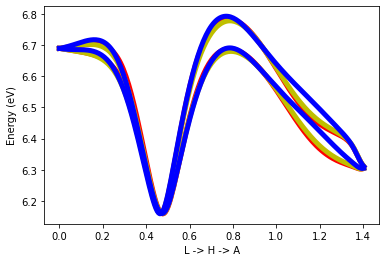

In [9]:
#plot band structure with unsymmetrized system
NK=len(band_k)
colour = ['r','y','b']
NK_one = NK//3
plt.figure()
for i in range(3):
    plt.plot(band_k[0:NK_one],band_Te[NK_one*i:NK_one*(i+1)],colour[i],linewidth=5)
plt.ylabel('Energy (eV)')
plt.xlabel('L -> H -> A')

Text(0.5, 0, 'L -> H -> A')

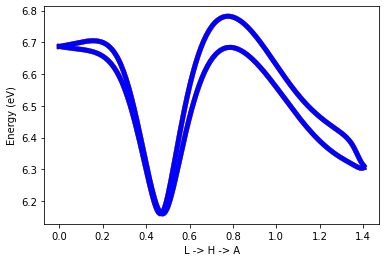

In [10]:
#plot band structure with symmetrized system
plt.figure()
for i in range(3):
    plt.plot(band_k[0:NK_one],band_Te_sym[NK_one*i:NK_one*(i+1)],colour[i],linewidth=5)
plt.ylabel('Energy (eV)')
plt.xlabel('L -> H -> A')

Symmetrization fix the symmetries of Hamiltonian

The Berry curvature is more sensitive to symmetry than energy eigenvalues.

In [11]:
# calculate Berry curvature alone a k-path.
path_berry=wberri.Path(system_Te,
                 k_nodes=[[0,0.5,0.5],[1./3,1./3,0.5],[1./3,1./3,0.]],
                 labels=["L","H","K",],
                 length=500)

quantities = {"Energy":wberri.calculators.tabulate.Energy(),
              "berry":wberri.calculators.tabulate.BerryCurvature(),}

calculators={}
calculators ["tabulate"] = wberri.calculators.TabulatorAll(quantities,ibands=[18,19],mode="path")

berry_result_Te = wberri.run(
        system=system_Te,
        grid=path_berry,
        calculators=calculators)

berry_result_Te_sym = wberri.run(
        system=system_Te_sym,
        grid=path_berry,
        calculators=calculators)

calculator not described

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x7f9b231c14f0>
All calculators are compatible
Symmetrization switched off for Path
The set of k points is a Path() with 80 points and labels {0: 'L', 37: 'H', 79: 'K'}
generating K_list
Done 
Done, sum of weights:80.0
iteration 0 - 80 points. New points are:
 K-point 0 : coord in rec.lattice = [   0.000000  ,   0.500000 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 1 : coord in rec.lattice = [   0.009009  ,   0.495495 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 2 : coord in rec.lattice = [   0.018018  ,   0.490991 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 3 : coord in rec.lattice = [   0.027027  ,   0.486486 ,    0.500000 ], refinement level:0, dK=[1. 1. 1.]  
 K-point 4 : coord in rec.lattice = [   0.036036  ,   0.481982 ,    0.500000 ], refinement level:0, 

                   1              0.0                   3.6
                   2              0.1                   3.0
                   3              0.1                   2.7
                   4              0.1                   2.5
                   5              0.2                   2.4
                   6              0.2                   2.3
                   7              0.2                   2.3
                   8              0.2                   2.2
                   9              0.3                   2.1
                  10              0.3                   2.1
                  11              0.3                   2.0
                  12              0.3                   2.0
                  13              0.4                   1.9
                  14              0.4                   1.8
                  15              0.4                   1.8
                  16              0.4                   1.7
                  17              0.5   

                   1              0.1                   6.4
                   2              0.1                   5.4
                   3              0.2                   5.0
                   4              0.3                   4.8
                   5              0.3                   4.6
                   6              0.4                   4.5
                   7              0.4                   4.4
                   8              0.5                   4.3
                   9              0.5                   4.2
                  10              0.6                   4.2
                  11              0.7                   4.1
                  12              0.7                   4.1
                  13              0.8                   4.0
                  14              0.8                   3.9
                  15              0.9                   3.9
                  16              0.9                   3.8
                  17              1.0   

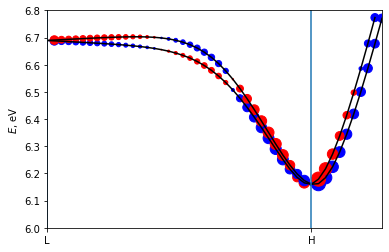

In [12]:
# use built-in plotting method to plot berry cuvature.
# red means positive, blue means negative.
# size of the dots shows the amplitude of the quantity.
# unsymmetrized:
berry_result_Te.results['tabulate'].plot_path_fat(path_berry,
              quantity='berry',
              component='z', # only take z compoment
              Emin=6.0,  Emax=6.8,
              mode="fatband",
              fatfactor=20,  # size of dots.
              )

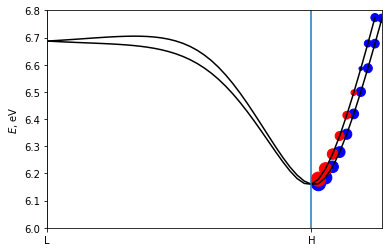

In [13]:
# symmetrized: 
berry_result_Te_sym.results['tabulate'].plot_path_fat(path_berry,
              quantity='berry',
              component='z', # only take z compoment
              Emin=6.0,  Emax=6.8,
              mode="fatband",
              fatfactor=20,  # size of dots.
              )

z-component of Berry curvature alone L-H path should be zero because of symmetry. The loss of symmetry has a big impact to Berry curvature of single k-point. It is fixed by symmetrization.

## Magnetic system with SOC (bcc Fe)

bcc Fe is a magnetic system with magnetic moment -2.31 \mu_B point to -z direction of cartesian coordinate system of lattice. We need to set parameter 'magmom'.

In [14]:
system_Fe=wberri.System_tb(tb_file='./Fe_data/Fe_tb.dat',berry=True, use_ws=False)
system_Fe_sym=wberri.System_tb(tb_file='./Fe_data/Fe_tb.dat',berry=True, use_ws=False)
system_Fe_sym.symmetrize(
             proj = ['Fe:sp3d2;t2g'],
             atom_name = ['Fe'],
             positions = [[0,0,0]],
             #magmom: magnetic moment of each atoms.
             magmom = [[0.,0.,-2.31]],
             soc=True,
             DFT_code = 'qe'
             )


reading TB file ./Fe_data/Fe_tb.dat ( written on 13May2022 at 01:23:14 )
NOT using ws_dist
Number of wannier functions: 18
Number of R points: 27
Recommended size of FFT grid [5 5 5]
Reading the system from ./Fe_data/Fe_tb.dat finished successfully
reading TB file ./Fe_data/Fe_tb.dat ( written on 13May2022 at 01:23:14 )
NOT using ws_dist
Number of wannier functions: 18
Number of R points: 27
Recommended size of FFT grid [5 5 5]
Reading the system from ./Fe_data/Fe_tb.dat finished successfully
Wannier atoms info
(1, 'Fe', [0, 0, 0], ['sp3d2', 't2g'], [[0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14], [6, 7, 8, 15, 16, 17]], [0.0, 0.0, -2.31])
[get_spacegroup]
  Spacegroup is Im-3m (229).
  ---------------    1 ---------------
 det =  1.0
  rotation:                    cart:
     [ 1  0  0]                    [1.00 0.00 -0.00]
     [ 0  1  0]                    [-0.00 1.00 -0.00]
     [ 0  0  1]                    [-0.00 -0.00 1.00]
  translation:
     ( 0.00000  0.00000  0.00000)  ( 0.00000  0

Symmetry operator 2 is respect to magnetic moment
rot =  2
Symmetry operator 3 is respect to magnetic moment
rot =  3
Symmetry operator 4 is respect to magnetic moment
rot =  4
Symmetry operator 5 is respect to magnetic moment
rot =  5
Symmetry operator 6 is respect to magnetic moment
rot =  6
Symmetry operator 7 is respect to magnetic moment
rot =  7
Symmetry operator 8 is respect to magnetic moment
rot =  8
Symmetry operator 9*T is respect to magnetic moment
rot =  9
Symmetry operator 10*T is respect to magnetic moment
rot =  10
Symmetry operator 11*T is respect to magnetic moment
rot =  11
Symmetry operator 12*T is respect to magnetic moment
rot =  12
Symmetry operator 13*T is respect to magnetic moment
rot =  13
Symmetry operator 14*T is respect to magnetic moment
rot =  14
Symmetry operator 15*T is respect to magnetic moment
rot =  15
Symmetry operator 16*T is respect to magnetic moment
rot =  16
number of symmetry oprations ==  16
nRvec_add = 0
Symmetrizing Finished
Testing AA wi

Important explanations:
1. The projection card in wannier90.win of bcc Fe is `'Fe':sp3d2;dxz,dyz,dxy`. But in the symmetrization, orbitals must project to complete sets of coordinates after symmetry opration. So we must label orbitals which shares the same complete sets of coordinates. eg: `sp3d2, dxz,dyz,dxy -> sp3d2, t2g` and `sp,px,py -> sp,p2`
2. We print out all the symmetry operators in the space group. But magnetic moments break some of them. Afte line `Symmetrizing start`. You can find details about which operator belong to the magnetic group.

bcc Fe have inversion symmetry, so the Berry curvature dipole should be zero. Ref: https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.115.216806

In [15]:
#calculate berry curvature dipole
Efermi_Fe = np.linspace(15.5,16,301)
NK = 10
result_Fe = wberri.run(system_Fe,
            grid=wberri.Grid(system_Fe,NK=NK,NKFFT=1),
            calculators = {"BerryDipole":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi_Fe,tetra=True)},
            adpt_num_iter=0,
            fout_name='Fe',
            restart=False,
            )
result_Fe_sym = wberri.run(system_Fe_sym,
            grid=wberri.Grid(system_Fe_sym,NK=NK,NKFFT=1),
            calculators = {"BerryDipole":wberri.calculators.static.BerryDipole_FermiSea(Efermi=Efermi_Fe,tetra=True)},
            adpt_num_iter=0,
            fout_name='Fe_sym',
            restart=False,
            )

determining grids from NK=10 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=1 (<class 'NoneType'>)
The grids were set to NKdiv=[10 10 10], NKFFT=[1 1 1], NKtot=[10 10 10]
Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`

Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[1 1 1], NKtot=[10 10 10]
generating K_list
Done in 0.03275012969970703 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.04643082618713379 s 
Done in 0.046715736389160156 s 
K_list contains 1000 Irreducible points(100.0%) out of initial 10x10x10=1000 grid
Done, sum of weights:1.0000000000000007
iteration 0 - 1000 points. New points are:
 K-point 0 : coord in rec.lattice = [   0.000000  ,   0.000000 ,    0.000000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 1 : coord in rec.lattice

 K-point 554 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.400000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 555 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.500000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 556 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.600000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 557 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.700000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 558 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.800000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 559 : coord in rec.lattice = [   0.500000  ,   0.500000 ,    0.900000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 560 : coord in rec.lattice = [   0.500000  ,   0.600000 ,    0.000000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 561 : coord in rec.lattice = [   0.500000  ,   0.600000 ,    0.100000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 562 : coord in rec.latt

 K-point 898 : coord in rec.lattice = [   0.800000  ,   0.900000 ,    0.800000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 899 : coord in rec.lattice = [   0.800000  ,   0.900000 ,    0.900000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 900 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.000000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 901 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.100000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 902 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.200000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 903 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.300000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 904 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.400000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 905 : coord in rec.lattice = [   0.900000  ,   0.000000 ,    0.500000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 906 : coord in rec.latt

                  10              3.2                 320.6
                  20              3.3                 163.5
                  30              3.4                 110.9
                  40              3.5                  84.7
                  50              3.6                  68.8
                  60              3.7                  58.2
                  70              3.8                  50.7
                  80              3.9                  45.0
                  90              4.0                  40.5
                 100              4.1                  36.9
                 110              4.2                  33.9
                 120              4.3                  31.4
                 130              4.4                  29.3
                 140              4.5                  27.5
                 150              4.6                  25.9
                 160              4.7                  24.5
                 170              4.8   

 K-point 781 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.100000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 782 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.200000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 783 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.300000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 784 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.400000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 785 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.500000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 786 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.600000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 787 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.700000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 788 : coord in rec.lattice = [   0.700000  ,   0.800000 ,    0.800000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 789 : coord in rec.latt

 K-point 879 : coord in rec.lattice = [   0.800000  ,   0.700000 ,    0.900000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 880 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.000000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 881 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.100000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 882 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.200000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 883 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.300000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 884 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.400000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 885 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.500000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 886 : coord in rec.lattice = [   0.800000  ,   0.800000 ,    0.600000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 887 : coord in rec.latt

 K-point 946 : coord in rec.lattice = [   0.900000  ,   0.400000 ,    0.600000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 947 : coord in rec.lattice = [   0.900000  ,   0.400000 ,    0.700000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 948 : coord in rec.lattice = [   0.900000  ,   0.400000 ,    0.800000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 949 : coord in rec.lattice = [   0.900000  ,   0.400000 ,    0.900000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 950 : coord in rec.lattice = [   0.900000  ,   0.500000 ,    0.000000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 951 : coord in rec.lattice = [   0.900000  ,   0.500000 ,    0.100000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 952 : coord in rec.lattice = [   0.900000  ,   0.500000 ,    0.200000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 953 : coord in rec.lattice = [   0.900000  ,   0.500000 ,    0.300000 ], refinement level:0, dK=[0.1 0.1 0.1]  
 K-point 954 : coord in rec.latt

                 260              2.6                   7.5
                 270              2.7                   7.4
                 280              2.8                   7.3
                 290              2.9                   7.2
                 300              3.0                   7.0
                 310              3.1                   6.9
                 320              3.2                   6.8
                 330              3.3                   6.7
                 340              3.4                   6.6
                 350              3.5                   6.5
                 360              3.6                   6.4
                 370              3.7                   6.3
                 380              3.8                   6.2
                 390              3.9                   6.1
                 400              4.0                   6.0
                 410              4.1                   5.9
                 420              4.2   

In [16]:
#read data
Fe_Morb = result_Fe.results["BerryDipole"].data 
Fe_sym_Morb = result_Fe_sym.results["BerryDipole"].data

Text(0, 0.5, 'Berry curvature dipole')

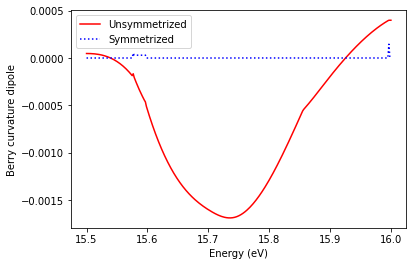

In [17]:
#unsymmetrized
#print zz component of berry dipole
fig=plt.figure()
plt.plot(Efermi_Fe,Fe_Morb[:,2,2],'r',label="Unsymmetrized") 
plt.plot(Efermi_Fe,Fe_sym_Morb[:,2,2],'b:',label="Symmetrized") 
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('Berry curvature dipole')

Symmetrized system gives us better results with low-density k-grid. The results around band intersections are not converged because the density of k-grid is too low. There are some sharp peaks at band intersection energy, we can see one of them in the plot.

# Have fun!